In [1]:
# import modules
import urllib
import json
from pprint import pprint
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# extract all the files from the zip folder to current working directory
from zipfile import ZipFile
from mapbox import Geocoder
import requests
from Config import token
import time
# You have to install some of these libs such as descartes, geopandas
# for geopandas, do "conda install geopandas" in cmd
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import style
import shapely.speedups
import seaborn as sns

In [3]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "8c233bc2-1879-44ff-a0e4-9b69a9032c54"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())
pprint(package)

{'help': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/help_show?name=package_show',
 'result': {'creator_user_id': '150d5301-86ec-44a3-a070-50f2cea839c9',
            'dataset_category': 'Document',
            'excerpt': 'This dataset contains non-identifiable information '
                       'relating to each parking ticket issued for each '
                       'calendar year since 2008.',
            'formats': 'XLS,ZIP',
            'groups': [],
            'id': '8c233bc2-1879-44ff-a0e4-9b69a9032c54',
            'information_url': 'http://www.toronto.ca/pay-toronto-tickets/parkingtickets/index.htm',
            'is_retired': False,
            'isopen': True,
            'last_refreshed': '2019-07-23T17:51:57.153365',
            'license_id': 'other-open',
            'license_title': 'Other (Open)',
            'metadata_created': '2019-07-23T17:50:14.331462',
            'metadata_modified': '2019-11-06T15:23:09.564050',
            'name': 'parking-ti

In [4]:
# Get data url for year 2016, 2017 and 2018 and download the zip files of each year, and extract them
for i in range(3):
    filedata_url = package["result"]["resources"][i+8]["url"]
    print(filedata_url)
    # Request the data online
    data = requests.get(filedata_url)
    #store the downloaded file in the parking2018.zip 
    open(f'Resources/parking201{i+6}.zip', 'wb').write(data.content)
    # Extract the zip file
    with ZipFile(f"Resources/parking201{i+6}.zip","r") as zfile:
        zfile.extractall("Resources")

https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/1044f9dc-208f-4011-895c-9497b8b9912a/download/parking-tickets-2016.zip
https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/3531cede-396a-48a2-af8d-ddd8ac8a8a63/download/parking-tickets-2017.zip
https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/e0df3b42-8515-492b-ba85-a55c4cfd035f/download/parking-tickets-2018.zip


In [5]:
# Read csv files of the parking data of year 2016, 2017, 2018

# Define a concatenate function to combine all the csv files of each year
def concatenate(*argmt):
    data_df = pd.DataFrame()
    for i in argmt:
        data_df = data_df.append(pd.read_csv(i))
    return data_df
complete_data_2016 = concatenate("Resources/Parking_Tags_Data_2016_1.csv","Resources/Parking_Tags_Data_2016_2.csv","Resources/Parking_Tags_Data_2016_3.csv","Resources/Parking_Tags_Data_2016_4.csv")
complete_data_2017 = concatenate("Resources/Parking_Tags_Data_2017_1.csv","Resources/Parking_Tags_Data_2017_2.csv","Resources/Parking_Tags_Data_2017_3.csv")
complete_data_2018 = concatenate("Resources/Parking_Tags_Data_2018_1.csv","Resources/Parking_Tags_Data_2018_2.csv","Resources/Parking_Tags_Data_2018_3.csv")

# Preview
complete_data_2018.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***92517,20180101,16,PARK-WITHIN 9M INTERSECT ROAD,50,0.0,S/S,PRYOR AVE,E/O,CLOVERDALE RD,ON
1,***71708,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,266 DOVERCOURT RD,NaN,NaN,ON
2,***92311,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,15 FAIRBANK AVE,NaN,NaN,ON
3,***92312,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,15 FAIRBANK AVE,NaN,NaN,ON
4,***71709,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,3.0,NR,266 DOVERCOURT RD,NaN,NaN,ON


In [6]:
# See the data types
complete_data_2018.dtypes

tag_number_masked          object
date_of_infraction          int64
infraction_code             int64
infraction_description     object
set_fine_amount             int64
time_of_infraction        float64
location1                  object
location2                  object
location3                  object
location4                  object
province                   object
dtype: object

In [7]:
# Fill the NaN cells with nothing inside it
new_data_2016 = complete_data_2016.fillna("")
new_data_2017 = complete_data_2017.fillna("")
new_data_2018 = complete_data_2018.fillna("")

# Preview
new_data_2016.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***03850,20160101,29,PARK PROHIBITED TIME NO PERMIT,30,0,NR,49 GLOUCESTER ST,,,ON
1,***03851,20160101,29,PARK PROHIBITED TIME NO PERMIT,30,1,NR,45 GLOUCESTER ST,,,ON
2,***98221,20160101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,274 GEORGE ST,,,ON
3,***85499,20160101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,270 GEORGE ST,,,ON
4,***03852,20160101,406,PARK-VEH. W/O VALID ONT PLATE,40,2,NR,45 GLOUCESTER ST,,,ON


In [8]:
# Group data set by dates for year 2018
grouped_data = new_data_2018.groupby("date_of_infraction")

# Show the grouped data
grouped_data.first().head()

,tag_number_masked,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
date_of_infraction,,,,,,,,,,
20180101,***92517,16,PARK-WITHIN 9M INTERSECT ROAD,50,0.0,S/S,PRYOR AVE,E/O,CLOVERDALE RD,ON
20180102,***37208,3,PARK ON PRIVATE PROPERTY,30,0.0,AT,50 GRAYDON HALL DR,,,ON
20180103,***86273,15,PARK-WITHIN 3M OF FIRE HYDRANT,100,2.0,NR,5095 YONGE ST,,,ON
20180104,***74668,29,PARK PROHIBITED TIME NO PERMIT,30,0.0,NR,55 MAITLAND ST,,,ON
20180105,***70908,29,PARK PROHIBITED TIME NO PERMIT,30,1.0,S/S,ST MARY ST,W/O,YONGE ST,ON


In [9]:
# Only for year 2018
# Get the address at which each infraction took place with date
# Create a blank dictionary to store addresses for specific dates
address_book = {}

# Loop through each date and extract addresses for the same day
for date in grouped_data:
    # Create a blank list to store addresses for the same day
    address = []
    # date_data represent a data set for a specific day, e.g. 20180101
    date_data = pd.DataFrame(date[1]) # Transfer the tuple into data frame
    for index, row in date_data.iterrows():
        # Adding all the addresses up into a list
        if row["location3"] != "":
            # if it is an interscetion of 2 streets, We will ignore this type of records for the heat mapping as it only consist of a small amount of the entire data set
            pass
        else:
            # if only a street with a unit number
            address.append(str(row["location2"]))
        address_book[date[0]] = address # update the address_book dict, date[0] is the date, e.g. 20180101

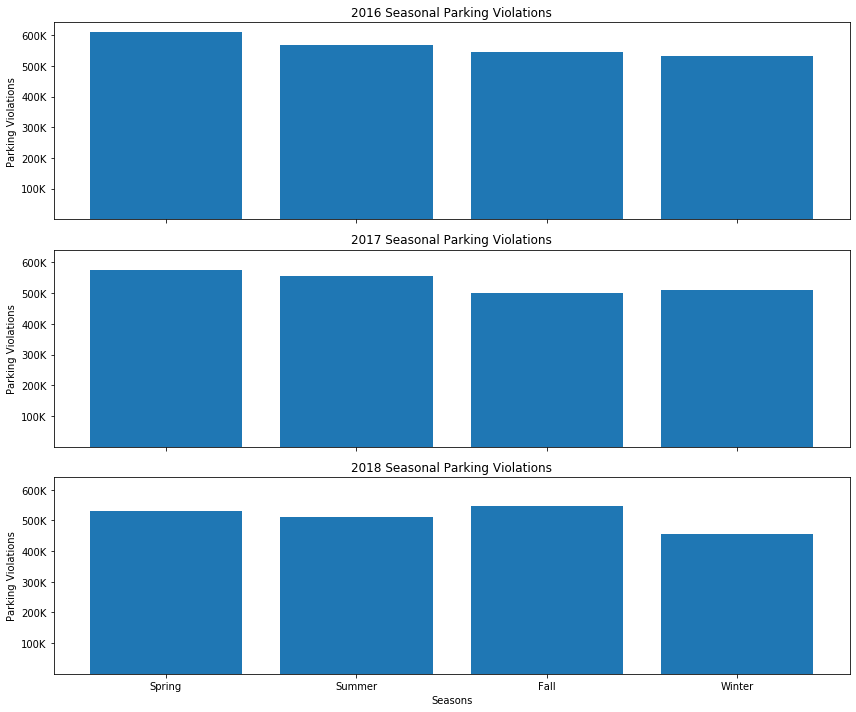

In [10]:
# Organize the data frame by seasons
# From the internet, 
# Spring - March 20 to June 20. Spring is a rainy season in most parts of Ontario. ...
# Summer - June 21 to September 21. ...
# Fall (or Autumn) - September 22 to December 20. ...
# Winter - December 21 to March 19.

# Create a figure with 3 sub plots
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,10),sharex = "col",sharey = True)

for index, item in enumerate([new_data_2016,new_data_2017,new_data_2018]):
    spring = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0320"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0620"))),:]
    summer = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0621"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0921"))),:]
    fall = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0922"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1220"))),:]
    winter = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1221"))) | (item["date_of_infraction"]<=(int(f"201{index+6}0319"))),:]
    
    # Get total tickets granted for each season
    num_tickets_spring = len(spring)
    num_tickets_summer = len(summer)
    num_tickets_fall = len(fall)
    num_tickets_winter = len(winter)

    # Bar chart for seasonal ticketing
    
    [ax1,ax2,ax3][index].bar([1,2,3,4],[num_tickets_spring, num_tickets_summer, num_tickets_fall, num_tickets_winter])
    
    plt.xticks([1,2,3,4],["Spring", "Summer", "Fall", "Winter"])
    plt.yticks([100000,200000,300000,400000,500000,600000],["100K","200K","300K","400K","500K","600K"])
    plt.xlabel("Seasons")
    [ax1,ax2,ax3][index].set_ylabel("Parking Violations")
    [ax1,ax2,ax3][index].set_title(f"{2016+index} Seasonal Parking Violations")
    plt.tight_layout()
    
# Save the bar chart
plt.savefig("Results/2016 Seasonal Parking Violations.png")

# Show the figure
plt.show()

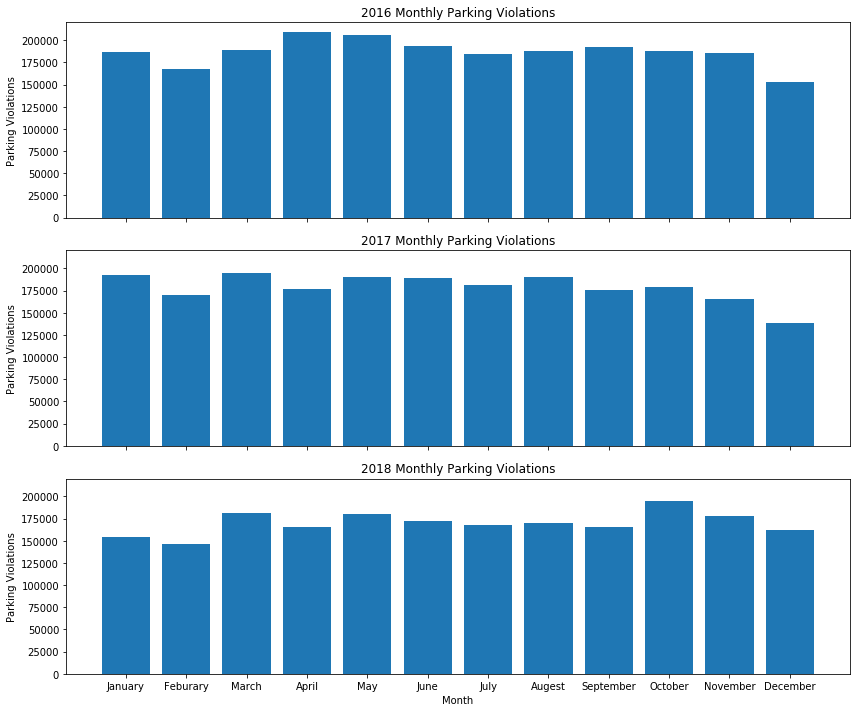

In [11]:
# Create a figure with 3 sub plots
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,10),sharex = "col",sharey = True)

for index, item in enumerate([new_data_2016,new_data_2017,new_data_2018]):
    # Organize the data frame by months
    Jan = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0101"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0131"))),:]
    Feb = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0201"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0228"))),:]
    Mar = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0301"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0331"))),:]
    Apr = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0401"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0430"))),:]
    May = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0501"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0531"))),:]
    Jun = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0601"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0630"))),:]
    Jul = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0701"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0731"))),:]
    Aug = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0801"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0831"))),:]
    Sep = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}0901"))) & (item["date_of_infraction"]<=(int(f"201{index+6}0930"))),:]
    Oct = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1001"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1031"))),:]
    Nov = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1101"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1130"))),:]
    Dec = item.loc[(item["date_of_infraction"]>=(int(f"201{index+6}1201"))) & (item["date_of_infraction"]<=(int(f"201{index+6}1230"))),:]

    tol_Jan = len(Jan)
    tol_Feb = len(Feb)
    tol_Mar = len(Mar)
    tol_Apr = len(Apr)
    tol_May = len(May)
    tol_Jun = len(Jun)
    tol_Jul = len(Jul)
    tol_Aug = len(Aug)
    tol_Sep = len(Sep)
    tol_Oct = len(Oct)
    tol_Nov = len(Nov)
    tol_Dec = len(Dec)

    # Bar chart for monthly ticketing
    [ax1,ax2,ax3][index].bar([1,2,3,4,5,6,7,8,9,10,11,12],[tol_Jan,tol_Feb,tol_Mar,tol_Apr,tol_May,tol_Jun,tol_Jul,tol_Aug,tol_Sep,tol_Oct,tol_Nov,tol_Dec])
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],["January", "Feburary", "March", "April","May","June","July","Augest","September","October","November","December"])
    plt.xlabel("Month")
    [ax1,ax2,ax3][index].set_ylabel("Parking Violations")
    [ax1,ax2,ax3][index].set_title(f"{2016+index} Monthly Parking Violations")
    plt.tight_layout()
# Save the bar chart
plt.savefig("Results/2016 Monthly Parking Violations.png")

# Show the figure
plt.show()

In [13]:
# Discover the 10 kinds of infractions drivers usually get the most
# Group data by infraction type
inf_type = new_data_2018.groupby("infraction_description").count()
most_viloated = list(inf_type.sort_values("tag_number_masked", ascending = False).head(10).index)
print("The first 10 most commited parking infractions:\n")
for i in most_viloated:
    print(f"No.{most_viloated.index(i)+1}: {i}")
    print("Total Infractions: " + str(inf_type.loc[i,"tag_number_masked"])+"\n")

The first 10 most commited parking infractions:

No.1: PARK ON PRIVATE PROPERTY
Total Infractions: 393451

No.2: PARK-SIGNED HWY-PROHIBIT DY/TM
Total Infractions: 337268

No.3: PARK PROHIBITED TIME NO PERMIT
Total Infractions: 298487

No.4: PARK MACHINE-REQD FEE NOT PAID
Total Infractions: 231652

No.5: PARK - LONGER THAN 3 HOURS
Total Infractions: 113134

No.6: STOP-SIGNED HWY-PROHIBIT TM/DY
Total Infractions: 103525

No.7: PARK-VEH. W/O VALID ONT PLATE
Total Infractions: 88263

No.8: STAND VEH.-PROHIBIT TIME/DAY
Total Infractions: 73121

No.9: STOP-SIGNED HIGHWAY-RUSH HOUR
Total Infractions: 67693

No.10: PARK-SIGNED HWY-EXC PERMT TIME
Total Infractions: 52498



In [17]:
# Use year 2018 for analysis, only get the records with specific address with it so we can plot it in the map 
location_df=new_data_2018.loc[new_data_2018['location4']==""]

In [18]:
location_df.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
1,***71708,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,266 DOVERCOURT RD,,,ON
2,***92311,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,15 FAIRBANK AVE,,,ON
3,***92312,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,15 FAIRBANK AVE,,,ON
4,***71709,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,3,NR,266 DOVERCOURT RD,,,ON
5,***73023,20180101,3,PARK ON PRIVATE PROPERTY,30,3,AT,735 COLLEGE ST,,,ON


In [19]:
# Revise the date format
location_df["Date"]= pd.to_datetime(location_df['date_of_infraction'].astype(str), format='%Y%m%d')
location_df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province,Date
1,***71708,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,266 DOVERCOURT RD,,,ON,2018-01-01
2,***92311,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,15 FAIRBANK AVE,,,ON,2018-01-01
3,***92312,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,2,NR,15 FAIRBANK AVE,,,ON,2018-01-01
4,***71709,20180101,29,PARK PROHIBITED TIME NO PERMIT,30,3,NR,266 DOVERCOURT RD,,,ON,2018-01-01
5,***73023,20180101,3,PARK ON PRIVATE PROPERTY,30,3,AT,735 COLLEGE ST,,,ON,2018-01-01


In [20]:
# Since the data set is too huge, we only use February data to do the analysis
February_df=location_df.loc[(location_df['Date'].dt.month==2)]

In [22]:
February_location_coordinates = pd.DataFrame({"location":February_df["location2"].unique()})
February_location_coordinates.head()
#response = geocoder.forward({location,bbox=[-79.646249,43.551428,-79.114444,43.882203],limit=1).json()
#response

,location
0,2531 LAKE SHORE BLVD W
1,118 GOTHIC AVE
2,259 DELORAINE AVE
3,50 QUEBEC AVE
4,305 SHAW ST


In [23]:
#create lat and lng columns for the location data
February_location_coordinates["Lat"]=''
February_location_coordinates["Lng"]=''
February_location_coordinates.head()

,location,Lat,Lng
0,2531 LAKE SHORE BLVD W,,
1,118 GOTHIC AVE,,
2,259 DELORAINE AVE,,
3,50 QUEBEC AVE,,
4,305 SHAW ST,,


In [48]:
# loop in to API to get all geo coorinates 
# it took around 3hrs for me to get all the coodinates, don't run this cell, 
# I save all coordinates in a csv file for view
num=0.1
for index, row in February_location_coordinates.iterrows(): 
        location = row["location"]
        print(location)
        try:
            time.sleep(num)
            response = geocoder.forward(location,bbox=[-79.646249,43.551428,-79.114444,43.882203],limit=1).json()
            print(f"Processing Record {(index+1)} of {len(February_location_coordinates)}")
            February_location_coordinates.loc[index, "Lat"] = response['features'][0]['center'][0]
            February_location_coordinates.loc[index, "Lng"] = response['features'][0]['center'][1]
        except:
            print("location not found. Skipping...")

2531 LAKE SHORE BLVD W
Processing Record 1 of 41834
118 GOTHIC AVE
Processing Record 2 of 41834
259 DELORAINE AVE
Processing Record 3 of 41834
50 QUEBEC AVE
Processing Record 4 of 41834
305 SHAW ST
Processing Record 5 of 41834
121 SCOLLARD ST
Processing Record 6 of 41834
128 MOUNTJOY AVE
Processing Record 7 of 41834
2468 EGLINTON AVE W
Processing Record 8 of 41834
110 CHARLES ST E
Processing Record 9 of 41834
49 HAZELTON AVE
Processing Record 10 of 41834
28 HOLBORNE AVE
Processing Record 11 of 41834
235 DELORAINE AVE
Processing Record 12 of 41834
1340 DANFORTH ROAD
Processing Record 13 of 41834
51 HAZELTON AVE
Processing Record 14 of 41834
325 QUEBEC AVE
Processing Record 15 of 41834
98 FORT YORK BLVD
Processing Record 16 of 41834
14 MEADOW AVE
Processing Record 17 of 41834
25 ST MARY ST
Processing Record 18 of 41834
88 CHARLES ST E
Processing Record 19 of 41834
15 WEBSTER AVE
Processing Record 20 of 41834
1 MEADOW AVE
Processing Record 21 of 41834
70 DAN LECKIE WAY
Processing Record 2

In [39]:
# realized lat and lng was wrong
raw_gdf=February_location_coordinates.rename(columns={"Lat": "Longitude", "Lng": "Latitude"})

In [44]:
# Add two columns
raw_gdf["Longitude float"]=pd.to_numeric(raw_gdf["Longitude"], downcast='float')
raw_gdf["Latitude float"]=pd.to_numeric(raw_gdf["Latitude"], downcast='float')
raw_gdf = raw_gdf.fillna("")
raw_gdf.head()

,location,Longitude,Latitude,Longitude float,Latitude float
0,2531 LAKE SHORE BLVD W,,,,
1,118 GOTHIC AVE,,,,
2,259 DELORAINE AVE,,,,
3,50 QUEBEC AVE,,,,
4,305 SHAW ST,,,,


In [47]:
# define one important variable for the geopandas
crs={'init':'epsg:4326'}
# Add a geometry column for the code to read
geometry=[Point(xy) for xy in zip(coordinates_df['Longitude float'],coordinates_df['Latitude float'])]

In [45]:
gdf=gpd.GeoDataFrame(coordinates_df,
                     crs=crs,
                    geometry=geometry)
gdf.head()
# Store the data
gdf.to_csv("data.csv",index = None)

,location,Longitude float,Latitude float,geometry
0,2531 LAKE SHORE BLVD W,-79.48730,43.610073,POINT (-79.4873 43.610073)
1,118 GOTHIC AVE,-79.46896,43.656223,POINT (-79.46896 43.656223)
2,259 DELORAINE AVE,-79.41404,43.731760,POINT (-79.41404 43.73175999999999)
3,50 QUEBEC AVE,-79.46808,43.654450,POINT (-79.46808 43.65445)
4,305 SHAW ST,-79.41826,43.650420,POINT (-79.41826 43.65042)


In [24]:
# after requesting the API, we saved all the data to the csv file so we don't need to call the API overtime 
#read saved coodinates file instead of loop through api again
file = "Results\data.csv"
coordinates_df=pd.read_csv(file)
coordinates_df.head()



,location,Longitude float,Latitude float,geometry
0,2531 LAKE SHORE BLVD W,-79.48730,43.610073,POINT (-79.48729705810547 43.61007308959961)
1,118 GOTHIC AVE,-79.46896,43.656223,POINT (-79.46896362304688 43.65622329711914)
2,259 DELORAINE AVE,-79.41404,43.731760,POINT (-79.41403961181641 43.73175811767578)
3,50 QUEBEC AVE,-79.46808,43.654450,POINT (-79.46807861328125 43.65444946289063)
4,305 SHAW ST,-79.41826,43.650420,POINT (-79.41825866699219 43.65042114257813)


In [25]:
# use geopandas to read map file
trt_map=gpd.read_file("Resources/25-ward-model-december-2018-wgs84-latitude-longitude/WARD_WGS84.shp")

In [26]:
%matplotlib inline

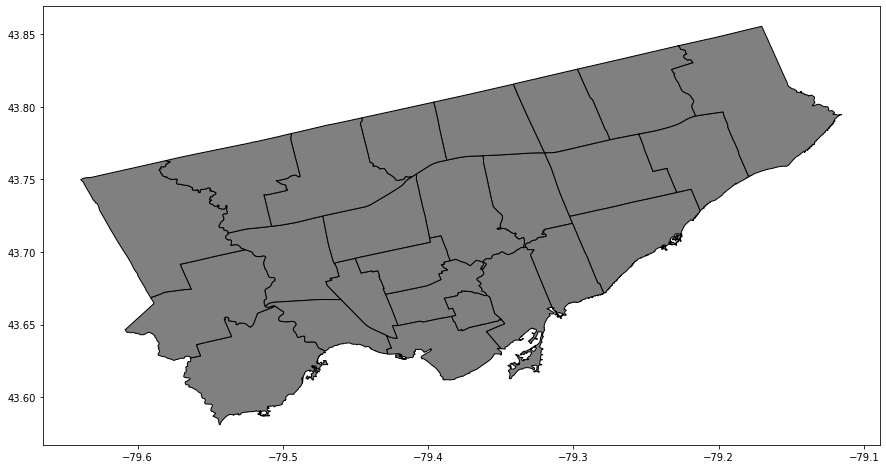

In [27]:
# View the map file 
style.use("seaborn-pastel")
fig,ax=plt.subplots(figsize=(15,15))
trt_map.plot(ax=ax,color="grey",edgecolor='black')

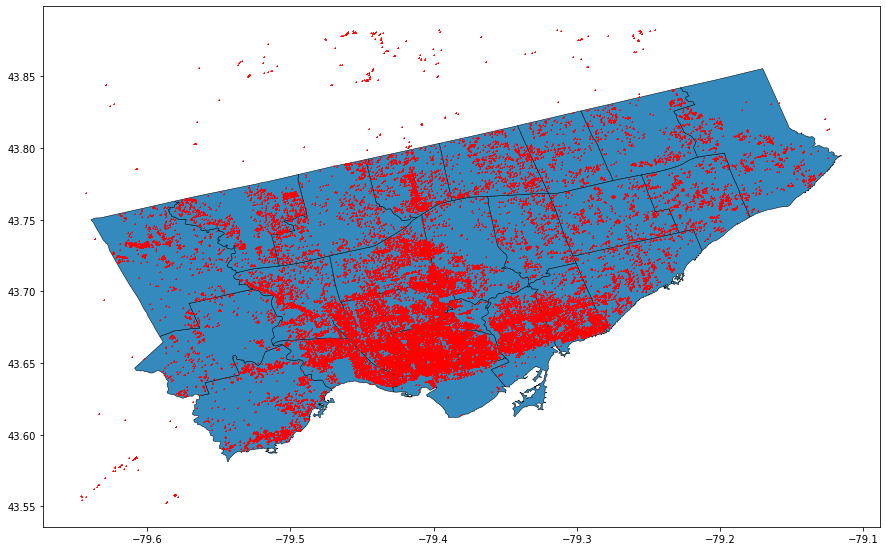

In [48]:
# Plot the violation distribution map
fig,ax=plt.subplots(figsize=(15,15))
plt.style.use('ggplot')
trt_map.plot(ax=ax,edgecolor='black')
gdf.plot(ax=ax,markersize=1,color="red",marker="+")
plt.savefig("Results/Parking tickets locations 2018 Feb.png")

In [49]:
trt_map.head()

,AREA_ID,AREA_TYPE,AREA_S_CD,AREA_L_CD,AREA_NAME,X,Y,LONGITUDE,LATITUDE,geometry
0,2551040,WD18,16,16,Don Valley East,318237.290,4844000.0,-79.33298,43.739716,"POLYGON ((-79.31334536599999 43.716986164, -79..."
1,2551044,WD18,03,03,Etobicoke-Lakeshore,303099.474,4831000.0,-79.52087,43.621646,"POLYGON ((-79.497766447 43.651983193, -79.4972..."
2,2551048,WD18,15,15,Don Valley West,314825.876,4843000.0,-79.37536,43.728396,"POLYGON ((-79.352321171 43.715734879, -79.3520..."
3,2551052,WD18,23,23,Scarborough North,324522.149,4852000.0,-79.25467,43.809672,"POLYGON ((-79.22590696100001 43.839601785, -79..."
4,2551056,WD18,11,11,University-Rosedale,313306.543,4837000.0,-79.39432,43.671139,"POLYGON ((-79.390039544 43.690503926, -79.3900..."


In [39]:
shapely.speedups.enable()

In [40]:
points_in_0=sum(gdf.within(trt_map.loc[0,'geometry']))
points_in_0

564

In [41]:
trt_map_count=trt_map.copy()

In [42]:
#Merge location df with February df and select wantted columns
Feb_all_data=February_df.merge(gdf, left_on='location2', right_on='location')
Feb_all_data_clean=Feb_all_data[['Date','location','Longitude float','Latitude float','geometry']]
Feb_all_data_clean.head()

,Date,location,Longitude float,Latitude float,geometry
0,2018-02-01,2531 LAKE SHORE BLVD W,-79.48730,43.610073,POINT (-79.4873 43.610073)
1,2018-02-01,2531 LAKE SHORE BLVD W,-79.48730,43.610073,POINT (-79.4873 43.610073)
2,2018-02-01,118 GOTHIC AVE,-79.46896,43.656223,POINT (-79.46896 43.656223)
3,2018-02-01,259 DELORAINE AVE,-79.41404,43.731760,POINT (-79.41404 43.73175999999999)
4,2018-02-01,50 QUEBEC AVE,-79.46808,43.654450,POINT (-79.46808 43.65445)


In [43]:
# now we need a geo dataframe
Feb_gdf = gpd.GeoDataFrame(Feb_all_data_clean, crs=crs, geometry=Feb_all_data_clean['geometry'])

In [44]:
# count points in 25 wards using within() 
count = []
for index,row in trt_map_count.iterrows():
    count.append(sum(Feb_gdf.within(trt_map_count.loc[index,'geometry'])))

In [46]:
#reading income dataframe from damir's notebook
%store -r income_df
income_df_trans=income_df.set_index('Income').T
df_income=income_df_trans.reset_index()
df_income

Income,index,Average,Median
0,Ward 1,73374,61169
1,Ward 2,128448,82870
2,Ward 3,105994,71859
3,Ward 4,99784,65546
4,Ward 5,67954,53469
5,Ward 6,86717,61725
6,Ward 7,65458,53530
7,Ward 8,162674,78626
8,Ward 9,80807,64866
9,Ward 10,103047,75825


In [47]:
#put count numbers and income back to the trtmap
trt_map_count["count"]=count
trt_map_count['ave income']=df_income['Average']
trt_map_count['med income']=df_income['Median']

In [48]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.resources import INLINE

In [49]:
clean_count=trt_map_count[['geometry','count']]

In [50]:
#convert data to json
data_json=json.loads(trt_map_count.to_json())

#convert to string like object
clean_json=json.dumps(data_json)

In [55]:
print(max(trt_map_count['count']))
print(min(trt_map_count['count']))

18293
975


In [56]:
from bokeh.plotting import figure, output_file, save

In [61]:
geosource = GeoJSONDataSource(geojson = clean_json)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 500, high = 20000)
#Define custom tick labels for color bar.
tick_labels = {'0': '1000', '5': '3000', '10':'5000', '15':'7000', 
               '20':'9000', '25':'11000', '30':'13000','35':'15000', '40': '>15000'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = 
                     tick_labels)

#Create figure object.
p = figure(title = 'Number of Parking Tickets on 25 Wards', plot_height = 600 ,
           plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' :'count', 
                                                      'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
output_file('Results\plot tickets.html', mode='inline')
save(p)

Loading BokehJS ...

'C:\\Users\\16478\\Data_Science\\UofT_DataBootcamp_Project_1\\Results\\plot tickets.html'

In [58]:
clean_count=trt_map_count[['geometry','med income']]

#convert data to json 
data_json=json.loads(trt_map_count.to_json())

#convert to string like object 
clean_json=json.dumps(data_json)

In [59]:
print(max(clean_count['med income']))
print(min(clean_count['med income']))

87360
51204


In [60]:
geosource = GeoJSONDataSource(geojson = clean_json)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 50000, high = 90000)
#Define custom tick labels for color bar.
tick_labels = {'0': '50000', '5': '55000', '10':'60000', '15':'65000', 
               '20':'70000', '25':'75000', '30':'80000','35':'85000', '40': '90000'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = 
                     tick_labels)

#Create figure object.
p = figure(title = 'Median income on 25 Wards', plot_height = 600 ,
           plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' :'med income', 
                                                      'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure and save
output_file('Results\plot income.html', mode='inline')
save(p)

Loading BokehJS ...

'C:\\Users\\16478\\Data_Science\\UofT_DataBootcamp_Project_1\\Results\\plot income.html'

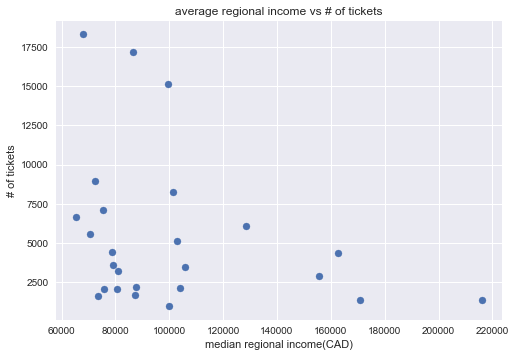

In [62]:
plt.style.use("seaborn")
# Build a scatter plot for each data type
plt.scatter(trt_map_count['ave income'],trt_map_count["count"], marker="o")

# Incorporate the other graph properties
plt.title('average regional income vs # of tickets')
plt.ylabel("# of tickets")
plt.xlabel("median regional income(CAD)")
plt.grid(True)
# Save the figure
plt.savefig("Results/average regional income vs # of tickets.png")
# Show plot
plt.show()

In [63]:
file=r"C:\Users\16478\Data_Science\UofT_DataBootcamp_Project_1\Resources\en_climate_daily_ON_TorontoIntA_2018.csv"
wDataTIA2018 = pd.read_csv(file)
weather_df = wDataTIA2018[['Date/Time', 'Mean Temp (°C)','Total Rain (mm)','Total Snow (cm)']]
weather_df.head()

,Date/Time,Mean Temp (°C),Total Rain (mm),Total Snow (cm)
0,2018-01-01,-15.0,0.0,0.0
1,2018-01-02,-10.5,0.0,1.0
2,2018-01-03,-9.9,0.0,0.0
3,2018-01-04,-14.7,0.0,0.0
4,2018-01-05,-19.0,0.0,0.0


In [72]:

date_df=pd.DataFrame(February_df['date_of_infraction'].value_counts(ascending=True))

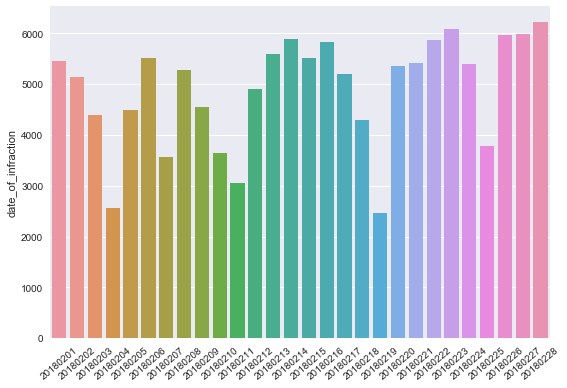

<Figure size 2592x720 with 0 Axes>

In [90]:
ax=sns.barplot(date_df.index,date_df["date_of_infraction"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
#ax.set_ylim(0,350)
plt.tight_layout()
plt.figure(figsize=(36,10))
plt.savefig("Results/tickets in Feb bar.png")
plt.show()

In [71]:
March_df=location_df.loc[(location_df['Date'].dt.month==3)]
date_df=pd.DataFrame(March_df['date_of_infraction'].value_counts(ascending=True))
ax=sns.barplot(date_df.index,date_df["date_of_infraction"])

ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
#ax.set_ylim(0,350)
plt.tight_layout()
plt.savefig("Results/tickets in March bar.png")
plt.show()


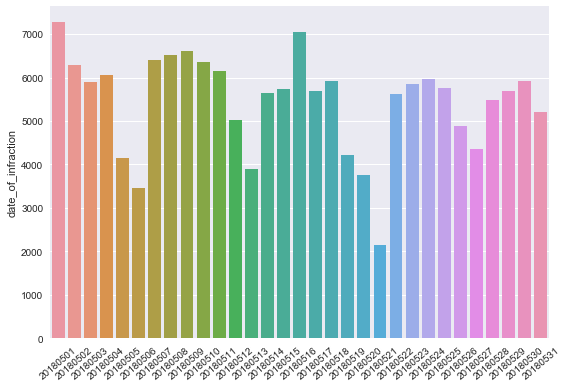

<Figure size 576x396 with 0 Axes>

In [69]:
May_df=location_df.loc[(location_df['Date'].dt.month==5)]
date_df=pd.DataFrame(May_df['date_of_infraction'].value_counts(ascending=True))
ax=sns.barplot(date_df.index,date_df["date_of_infraction"])

ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
#ax.set_ylim(0,350)
plt.tight_layout()
plt.savefig("Results/tickets in May bar.png")
plt.show()

In [74]:
new_data['Date'] = pd.to_datetime(new_data['date_of_infraction'].astype(str), format='%Y%m%d')
weekday = new_data.groupby(new_data["Date"].dt.weekday_name).count()
#print(week_df)
week_df=pd.DataFrame(weekday)

In [75]:
mon_ave=week_df.iloc[1]['tag_number_masked']/53
week_df['ave weekdays']=week_df['tag_number_masked']/52
week_df['ave weekdays'][1]=mon_ave
week_df

C:\Users\16478\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province,Date,ave weekdays
Date,,,,,,,,,,,,,
Friday,317660,317660,317660,317660,317660,317660,317660,317660,317660,317660,317660,317660,6108.846154
Monday,287496,287496,287496,287496,287496,287496,287496,287496,287496,287496,287496,287496,5424.452830
Saturday,258348,258348,258348,258348,258348,258348,258348,258348,258348,258348,258348,258348,4968.230769
Sunday,203519,203519,203519,203519,203519,203519,203519,203519,203519,203519,203519,203519,3913.826923
Thursday,326476,326476,326476,326476,326476,326476,326476,326476,326476,326476,326476,326476,6278.384615
Tuesday,325476,325476,325476,325476,325476,325476,325476,325476,325476,325476,325476,325476,6259.153846
Wednesday,325313,325313,325313,325313,325313,325313,325313,325313,325313,325313,325313,325313,6256.019231


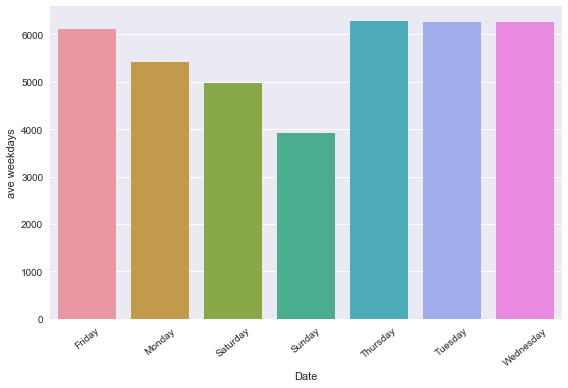

In [76]:
ax=sns.barplot(week_df.index,week_df["ave weekdays"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
plt.tight_layout()
plt.savefig("Results/weekday result.png")
plt.show()

#plt.savefig('tickets in May .png', dpi=fig.dpi)

In [77]:
day_df=pd.DataFrame(new_data['date_of_infraction'].value_counts())
df_1=day_df.reset_index()
df_2=df_1.rename(columns={"index": "date", "date_of_infraction": "count"})
df_2["date"]= pd.to_datetime(df_2['date'].astype(str), format='%Y%m%d')
count_df=df_2.sort_values(by='date').reset_index()
count_df.drop(['index'], axis=1,inplace=True)
#print(count_df.head())
#print(weather_df.head())
weather_df['count']=count_df['count']
weather_df
#weather_and_count_data=df_2.merge(weather_df, left_on='date', right_on='Date/Time')

C:\Users\16478\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Date/Time,Mean Temp (°C),Total Rain (mm),Total Snow (cm),count
0,2018-01-01,-15.0,0.0,0.0,1269
1,2018-01-02,-10.5,0.0,1.0,5489
2,2018-01-03,-9.9,0.0,0.0,5104
3,2018-01-04,-14.7,0.0,0.0,5002
4,2018-01-05,-19.0,0.0,0.0,4177
5,2018-01-06,-20.0,0.0,0.0,2831
6,2018-01-07,-11.5,0.2,0.2,3039
7,2018-01-08,-0.2,0.6,4.0,4424
8,2018-01-09,-1.0,0.0,0.0,6101
9,2018-01-10,0.9,2.6,0.0,5849


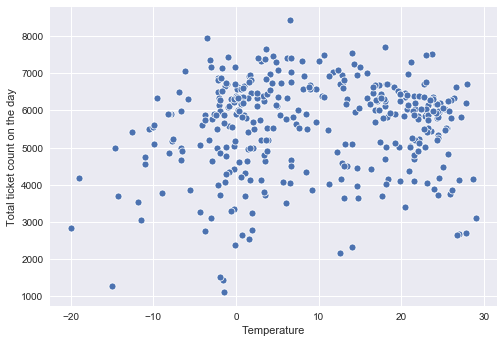

In [78]:
sns.scatterplot(y=weather_df['count'], x=weather_df['Mean Temp (°C)']);
plt.xlabel("Temperature")
plt.ylabel("Total ticket count on the day")
plt.savefig("Results/temperature vs tickers.png")
plt.show()

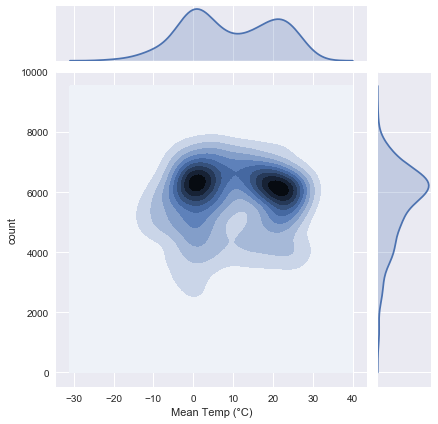

In [80]:
sns.jointplot(y=weather_df['count'],x=weather_df['Mean Temp (°C)'],kind="kde")
plt.savefig("Results/temperature vs tickers KDE.png")

In [81]:
weather_df.head(10)

,Date/Time,Mean Temp (°C),Total Rain (mm),Total Snow (cm),count
0,2018-01-01,-15.0,0.0,0.0,1269
1,2018-01-02,-10.5,0.0,1.0,5489
2,2018-01-03,-9.9,0.0,0.0,5104
3,2018-01-04,-14.7,0.0,0.0,5002
4,2018-01-05,-19.0,0.0,0.0,4177
5,2018-01-06,-20.0,0.0,0.0,2831
6,2018-01-07,-11.5,0.2,0.2,3039
7,2018-01-08,-0.2,0.6,4.0,4424
8,2018-01-09,-1.0,0.0,0.0,6101
9,2018-01-10,0.9,2.6,0.0,5849


In [82]:
#select days with rains and days with snow
#rain_df=weather
rain_df=weather_df.loc[weather_df['Total Rain (mm)']>0 & (weather_df['Total Snow (cm)']!=0)]
snow_df=weather_df.loc[weather_df['Total Snow (cm)']>0 & (weather_df['Total Rain (mm)']!=0)]
rain_snow_df=weather_df.loc[(weather_df['Total Rain (mm)']!=0) & (weather_df['Total Snow (cm)']!=0)]
other_df=weather_df.loc[(weather_df['Total Rain (mm)']==0) & (weather_df['Total Snow (cm)']==0)]
other_df

,Date/Time,Mean Temp (°C),Total Rain (mm),Total Snow (cm),count
0,2018-01-01,-15.0,0.0,0.0,1269
2,2018-01-03,-9.9,0.0,0.0,5104
3,2018-01-04,-14.7,0.0,0.0,5002
4,2018-01-05,-19.0,0.0,0.0,4177
5,2018-01-06,-20.0,0.0,0.0,2831
8,2018-01-09,-1.0,0.0,0.0,6101
12,2018-01-13,-14.3,0.0,0.0,3702
13,2018-01-14,-11.9,0.0,0.0,3541
17,2018-01-18,-6.6,0.0,0.0,5991
18,2018-01-19,-2.2,0.0,0.0,6506


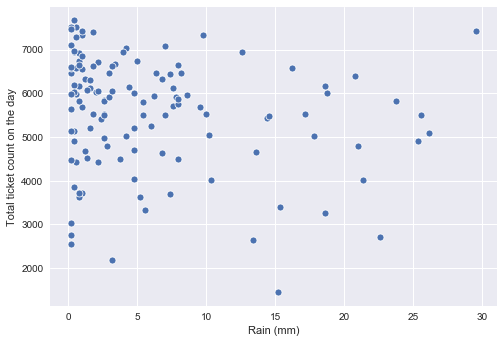

In [84]:
sns.scatterplot(y=rain_df['count'], x=rain_df['Total Rain (mm)']);
plt.xlabel("Rain (mm)")
plt.ylabel("Total ticket count on the day")
plt.savefig("Results/Rain vs tickers.png")
plt.show()

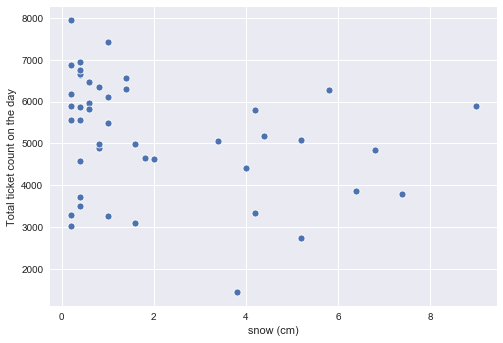

In [85]:
sns.scatterplot(y=snow_df['count'], x=snow_df['Total Snow (cm)']);
plt.xlabel("snow (cm)")
plt.ylabel("Total ticket count on the day")
plt.savefig("Results/snow vs tickets.png")
plt.show()

In [86]:
a=other_df['count'].mean()
b=rain_df['count'].mean()
c=snow_df["count"].mean()
d=rain_snow_df['count'].mean()

In [87]:
counts=[a,b,c,d]
df_weather_type=pd.DataFrame({"other":a,'rain':b,"snow":c,"rain and snow":d},index=[0])
df_weather_type

,other,rain,snow,rain and snow
0,5648.850962,5584.724409,5193.977778,5020.705882


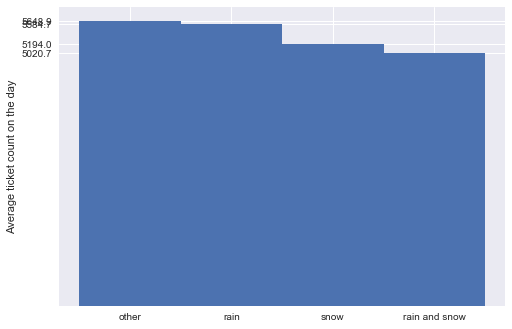

In [88]:
e=[("other",a),('rain',b),("snow",c),("rain and snow",d)]

labels, ys = zip(*e)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)
plt.ylabel("Average ticket count on the day")
plt.savefig("Results/weather type bar.png")